# Resample dataset from irregular time to regular time 
(constant sampling rate)

This example shows how to given a folder with PNG radar files, create a new folder with PNG files correspoding to the same event but with even time.

This does an interpolation at image level in Cartesian coordinates. Potentially, doing an advection correction would be wise.

\*IMPORTANT\*  
If planned to create a whole training dataset I would hihgly recommend taking a completely different approach, like doing the interpolation at ar2v level instead of using PNG files. And most important in polar coordinates, so the interpolation is ray-wise.

In [1]:
import numpy as np
import pandas as pd
import sys, os
from PIL import Image
import datetime
import copy
import imageio

Set the directory with png files. IMPORTANT: not by default in the repository, use "Making Datasets" example to get one.

In [2]:
directory = '../data/auxiliary_dataset/event1/history/PNG'

In [8]:
def getTime(file):
    return datetime.datetime.strptime(file[4:-13], '%Y%m%d_%H%M%S')
    
def getImage(directory, file):
    png = Image.open(directory+'/'+file)
    img = np.array(png, dtype='uint8')
    return img.flatten().reshape(1,-1)

def getRadar(file):
    return file[:4]

Load each image, get the time information from the title, and put all in a panda dataframe

In [11]:
first = True
i = 0
for subdir, dirs, files in os.walk(directory):
    #print(subdir, dirs, files)
    for f in files:
        if not f.endswith('png'): continue
        time = getTime(f)
        img  = getImage(directory, f)
        df_aux = pd.DataFrame(img)
        df_aux['time']=time
        if first:
            df = df_aux
            first = False
        else:
            df = df.append(df_aux, ignore_index=False, verify_integrity=False, sort=None)
        i += 1
df = df.sort_values(by=['time'])
df = df.set_index('time')

Display the dataframe with the time as index and the 64x64 pixels flatten to a single row.

In [13]:
df

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
time,,,,,,,,,,,,,,,,,,,,,
2019-04-07 17:23:46,48,52,51,56,55,50,43,41,41,48,...,0,0,0,0,0,0,0,0,0,0
2019-04-07 17:27:44,56,54,50,62,62,49,38,38,43,51,...,0,0,0,0,0,0,0,0,0,0
2019-04-07 17:31:42,55,48,56,64,61,41,40,40,45,51,...,0,0,0,0,0,0,0,0,0,0
2019-04-07 17:35:28,0,50,53,59,56,42,40,43,48,51,...,0,0,0,0,0,0,0,0,0,0
2019-04-07 17:39:14,0,0,48,57,51,41,40,43,49,54,...,0,0,0,0,0,0,0,0,0,0
2019-04-07 17:42:59,0,0,40,40,42,40,40,45,57,59,...,0,0,0,0,0,0,0,0,0,0
2019-04-07 17:46:44,0,0,0,41,40,39,41,47,56,66,...,0,0,0,0,0,0,0,0,0,0
2019-04-07 17:50:44,0,0,0,52,37,40,42,47,65,73,...,0,0,0,0,0,0,0,0,0,0
2019-04-07 17:54:42,0,0,36,36,40,38,41,47,70,85,...,0,0,0,0,0,0,0,0,0,0


Use pandas resampling function

In [21]:
new_sampling_rate = '5min'
resample_index = pd.date_range(start=df.index[0], end=df.index[-1], freq=new_sampling_rate)
dummy_frame = pd.DataFrame(np.NaN, index=resample_index, columns=df.columns)
df_resampled = df.combine_first(dummy_frame).interpolate('time').astype('uint8')
df_resampled = df_resampled.loc[resample_index]

Display new data, notice the time stamp is evenly distributed. Also, the number of frames will most likely change.

In [15]:
df_resampled

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
2019-04-07 17:23:46,48,52,51,56,55,50,43,41,41,48,...,0,0,0,0,0,0,0,0,0,0
2019-04-07 17:28:46,55,52,51,62,61,46,38,38,43,51,...,0,0,0,0,0,0,0,0,0,0
2019-04-07 17:33:46,24,49,54,61,58,41,40,41,46,51,...,0,0,0,0,0,0,0,0,0,0
2019-04-07 17:38:46,0,6,48,57,51,41,40,43,48,53,...,0,0,0,0,0,0,0,0,0,0
2019-04-07 17:43:46,0,0,31,40,41,39,40,45,56,60,...,0,0,0,0,0,0,0,0,0,0
2019-04-07 17:48:46,0,0,0,46,38,39,41,47,60,69,...,0,0,0,0,0,0,0,0,0,0
2019-04-07 17:53:46,0,0,27,39,39,38,41,47,68,82,...,0,0,0,0,0,0,0,0,0,0
2019-04-07 17:58:46,0,0,0,0,35,36,37,48,66,76,...,0,0,0,0,0,0,1,0,0,0
2019-04-07 18:03:46,0,0,0,22,35,36,34,41,61,74,...,0,0,0,0,0,0,29,0,0,0
2019-04-07 18:08:46,0,0,0,0,33,31,31,35,48,63,...,0,0,0,0,0,0,0,0,0,0


Plot original and resample, to be sure it makes sense. They should be really similar.

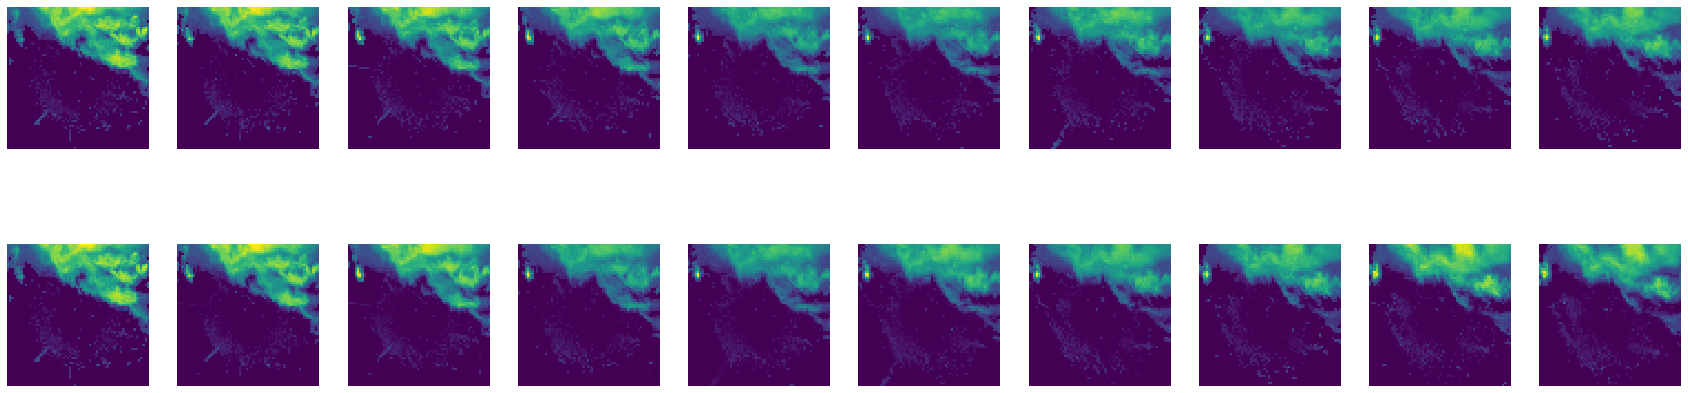

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,8))
for i in range(10):
    plt.subplot(2,10,i+1)
    img = np.array(df.iloc[i]).reshape(64,64)
    plt.imshow(img)
    plt.axis('off')
    #lt.tight_layout()
        
    plt.subplot(2,10,i+11)
    img = np.array(df_resampled.iloc[i]).reshape(64,64)
    plt.imshow(img)
    plt.axis('off')
    #lt.tight_layout()
plt.show()

Save the new data as images

In [28]:
new_directory = directory+'_resampled/'
radar = 'KFWS'
try:
    os.mkdir(new_directory)
except:
    pass
for index, row in df_resampled.iterrows():
    img = np.array(row).reshape(64,64).astype('uint8')
    name = radar + str(index).replace(' ','_').replace('-','').replace(':','') + '_v06.png'
    imageio.imwrite(new_directory+name,img)